<a href="https://colab.research.google.com/github/YIBoX-memorial/ReinforcementLearning/blob/master/A_k_armed_Bandit_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The document contains tests in the *Reinforcement Learning, Chapter 2, A k-armed Bandit Problem*

# Modules

In [22]:
from math import exp
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# Prototype of Distribution Generator

A general distribution generator model.

In [23]:
class Generator:
    __valid_types = ['normal', 'Poisson', 'uniform']
    def __init__(self, dtype:str='None', *args, **kwargs):
        flag = False
        if type != 'None':
            for type_i in __valid_types:
                if type_i == __valid_types:
                    flag = True
                    break
        if flag == False:
            raise TypeError("Invalid Distribution Types!")
    def output(self, *args, **kwargs):
        pass

# Normal Random Distribution Generator

A normal random distribution generator with \\(\mathcal{N}(\mu,\sigma)\\).


In [24]:
class Normal_Generator(Generator):
    def __init__(self, dtype:str='normal', mean:float=0.0, deviation:float=1.0, *args, **kwargs):
        super(dtype).__init__()
        self.__mean=mean
        self.__deviation=deviation
    def output(self, *args, **kwargs):
        # print(self.__mean, self.__deviation, args)
        return npr.normal(self.__mean, self.__deviation, args)

# RL Framework

RL Framework contains *value function, action, and observation*.


1.   Get the observation from the history and environment.
2.   Follow the policy and take action.
3.   Recycle 1 and 2

This RL Framework is typically the prototype for discrete-time RL.



In [25]:
class RLFramework:
    def __init__(self):
        pass
    def action(self):
        pass
    def observation(self):
        pass
    def value(self):
        pass

# \\(\epsilon\\)-Greedy policy

for a k-bandit problem.

In [26]:
class Epsilon_Greedy(RLFramework):
    def __init__(self, epsilon:float=0.0, opt_num:int=0, *args, **kwargs):
        super().__init__()
        self.__epsilon = epsilon
        self.__initiation = 0.0
        for kw in kwargs:
            if kw == 'initiation':
                self.__initiation = kwargs[kw]
        self.__value = np.full(shape=opt_num, fill_value=self.__initiation, dtype=float)
        self.__accumulation = np.full(shape=opt_num, fill_value=0, dtype=int)
        self.__last_action = None
        self.__recv = {}
        self.__observ = {}
    # Reset the agent
    def reset(self, *args, **kwargs):
        self.__value.fill(self.__initiation)
        self.__accumulation.fill(0)
        self.__recv.clear()
        self.__observ.clear()
    # Observe the environment
    def observation(self, selection:int=-1, reward:float=0.0, *args, **kwargs):
        self.__observ[selection] = reward
    # Receive the reward from environment
    def receive(self, selection:int=-1, reward:float=0.0, *args, **kwargs):
        self.__recv[selection] = reward
    # Update the agents' memory
    def update(self, *args, **kwargs):
        for kw in self.__recv:
            if kw != -1:
                reward = self.__recv[kw]
                self.__accumulation[kw] = self.__accumulation[kw]+1
                self.__value[kw] = self.__value[kw]+(self.__recv[kw]-self.__value[kw])/self.__accumulation[kw]
        self.__recv.clear()
    # Take action
    def action(self, *args, **kwargs):
        self.update()
        selection = 0
        for (ind, value) in enumerate(self.__value):
            if value > self.__value[selection]:
                selection = ind
        rand = npr.uniform(low=0, high=1)
        if rand < self.__epsilon:
            selection = npr.randint(low=0, high=10)
        return selection
    # Check value
    def check_value(self):
        for iter in self.__value:
            print(iter, ' ')
        print('\n')

# Stochastic Gradient Ascent

The SGA computes the probability \\(\pi_t(A_t)\\) from the preference \\(H_t(A_t)\\).

\\(\pi_t(a)=\frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}\\)

\\(H_{t+1}(A_t)=H_t(A_t)+\alpha(R_t-\bar{R}_t)(1-\pi_t(A_t))\\)
if \\(a=A_t\\)

\\(H_{t+1}(a)=H_t(a)+\alpha(R_t-\bar{R}_t)\pi_t(a)\\)
if \\(a\neq A_t\\)

In [27]:
class SGA(RLFramework):
    def __init__(self, step_size:float=0.0, opt_num:int=0, *args, **kwargs):
        self.__value = 0.0
        self.__accumulation = 0.0
        self.__memory = 0
        self.__probability = np.full(shape=opt_num, fill_value=1.0/opt_num, dtype=float)
        self.__preference = np.full(shape=opt_num, fill_value=0.0, dtype=float)
        self.__last_action = -1
        self.__step_size = step_size
    def reset(self, *args, **kwargs):
        self.__value = 0.0
        self.__accumulation = 0.0
        self.__memory = 0
        size = self.__preference.size
        # print('size: ', size)
        self.__probability = np.full(shape=size, fill_value=1.0/size, dtype=float)
        self.__preference = np.full(shape=size, fill_value=0.0, dtype=float)
        self.__last_action = -1
    # Calculate probability
    def cal_probability(self, *args, **kwargs):
        total = 0.0
        for iter in self.__preference:
            total = total + exp(iter)
        for (index, preference) in enumerate(self.__preference):
            self.__probability[index] = exp(self.__preference[index])/total
    def cal_preference(self, reward:float=0, *args, **kwargs):
        for (index, preference) in enumerate(self.__preference):
            if index != self.__last_action:
                self.__preference[index] = preference+self.__step_size*(reward-self.__accumulation)*(self.__probability[index])
            else:
                self.__preference[index] = preference+self.__step_size*(reward-self.__accumulation)*(1-self.__probability[index])
    def receive(self, reward:float, *args, **kwargs):
        self.cal_preference(reward)
        self.cal_probability()
        self.__memory = self.__memory+1
        self.__accumulation = self.__accumulation+(reward-self.__accumulation)/self.__memory
    def action(self, *args, **kwargs):
        selection = 0
        for (index, probability) in enumerate(self.__probability):
            if self.__probability[selection] < probability:
                selection = index
        self.__last_action = selection
        return selection

# Environment

The environment contains 10 choices, each choice returns a normally distributed reward.

In [28]:
class Environment:
    def __init__(self, *args, **kwargs):
        pass
    def reward(self, action, *args, **kwargs):
        pass

In [29]:
class TenArmed(Environment):
    def __init__(self, opt_num:int=0, *args, **kwargs):
        self.__responsors = [Normal_Generator(dtype=float, mean=npr.normal(loc=0.0, scale=1.0), deviation=1.0) for iter in range(opt_num)]
    def reset(self, *args, **kwargs):
        for iter in range(len(self.__responsors)):
            self.__responsors[iter] = Normal_Genenator(dtype=float, mean=npr.normal(loc=0.0, scale=1.0), deviation=1.0)
    def reward(self, action:int=0, *args, **kwargs):
        # print('action: ', action)
        return self.__responsors[action].output()

In [30]:
class ModifiedTenArmed(Environment):
    def __init__(self, opt_num:int=0, *args, **kwargs):
        self.__responsors = [Normal_Generator(dtype=float, mean=0.0, deviation=0.01) for iter in range(opt_num)]
        self.__last_response = [0.0 for iter in range(opt_num)]
    def reset(self, *args, **kwargs):
        for (index, value) in enumerate(self.__last_response):
            self.__last_response[index] = 0.0
    def reward(self, action:int=0, *args, **kwargs):
        self.__last_response[action] = self.__last_response[action]+self.__responsors[action].output()
        return self.__last_response[action]

# Interaction

In [31]:
class Interaction:
    total_trials = 2000
    total_opt = 10
    total_step = 1000
    agent_0 = Epsilon_Greedy(opt_num=total_opt)
    agent_0d1 = Epsilon_Greedy(epsilon=0.1, opt_num=total_opt)
    agent_i5 = Epsilon_Greedy(opt_num=total_opt, initiation=5)
    agent_sga = SGA(step_size=0.1, opt_num=total_opt)
    env = ModifiedTenArmed(opt_num=total_opt)
    def plot(self, *args, **kwargs):
        axis_x = np.arange(0, self.total_step)
        plt.plot(axis_x, self.sum_0, 'b', axis_x, self.sum_0d1, 'g', axis_x, self.sum_i5, 'r', axis_x, self.sum_sga, 'y')
        # plt.axis([0, self.total_step, -2, 2])
        plt.show()
    def process(self, *args, **kwargs):
        self.sum_0 = np.full(shape=self.total_step, fill_value=0.0, dtype=float)
        self.sum_0d1 = np.full(shape=self.total_step, fill_value=0.0, dtype=float)
        self.sum_i5 = np.full(shape=self.total_step, fill_value=0.0, dtype=float)
        self.sum_sga = np.full(shape=self.total_step, fill_value=0.0, dtype=float)
        for epoch in range(self.total_trials):
            self.agent_0.reset()
            self.agent_0d1.reset()
            self.agent_i5.reset()
            self.agent_sga.reset()
            self.env.reset()
            if epoch%100 == 0:
                print('epoch: ', epoch)
            for step in range(self.total_step):
                act = self.agent_0.action()
                reward = self.env.reward(act)
                self.agent_0.receive(act, reward)
                self.sum_0[step] = self.sum_0[step]+reward

                act = self.agent_0d1.action()
                reward = self.env.reward(act)
                self.agent_0d1.receive(act, reward)
                self.sum_0d1[step] = self.sum_0d1[step]+reward

                act = self.agent_i5.action()
                reward = self.env.reward(act)
                self.agent_i5.receive(act, reward)
                self.sum_i5[step] = self.sum_i5[step]+reward

                act = self.agent_sga.action()
                reward = self.env.reward(act)
                self.agent_sga.receive(reward)
                self.sum_sga[step] = self.sum_sga[step]+reward
        for step in range(self.total_step):
            self.sum_0[step] = self.sum_0[step]/self.total_trials
            self.sum_0d1[step] = self.sum_0d1[step]/self.total_trials
            self.sum_i5[step] = self.sum_i5[step]/self.total_trials
            self.sum_sga[step] = self.sum_sga[step]/self.total_trials

# Run

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900


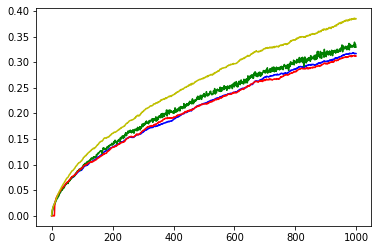

In [32]:
WORLD = Interaction()

WORLD.process()
WORLD.plot()